In [1]:
import torch
def euler2mat(angle):
    """Convert euler angles to rotation matrix.
     :param angle: [3] or [b, 3]
     :return
        rotmat: [3] or [b, 3, 3]
    source
    https://github.com/ClementPinard/SfmLearner-Pytorch/blob/master/inverse_warp.py
    """

    if len(angle.size()) == 1:
        x, y, z = angle[0], angle[1], angle[2]
        _dim = 0
        _view = [3, 3]
    elif len(angle.size()) == 2:
        b, _ = angle.size()
        x, y, z = angle[:, 0], angle[:, 1], angle[:, 2]
        _dim = 1
        _view = [b, 3, 3]

    else:
        assert False

    cosz = torch.cos(z)
    sinz = torch.sin(z)

    # zero = torch.zeros([b], requires_grad=False, device=angle.device)[0]
    # one = torch.ones([b], requires_grad=False, device=angle.device)[0]
    zero = z.detach()*0
    one = zero.detach()+1
    zmat = torch.stack([cosz, -sinz, zero,
                        sinz, cosz, zero,
                        zero, zero, one], dim=_dim).reshape(_view)

    cosy = torch.cos(y)
    siny = torch.sin(y)

    ymat = torch.stack([cosy, zero, siny,
                        zero, one, zero,
                        -siny, zero, cosy], dim=_dim).reshape(_view)

    cosx = torch.cos(x)
    sinx = torch.sin(x)

    xmat = torch.stack([one, zero, zero,
                        zero, cosx, -sinx,
                        zero, sinx, cosx], dim=_dim).reshape(_view)

    rot_mat = xmat @ ymat @ zmat
    # print(rot_mat)
    return rot_mat


def rotate_angle_vector(theta, v):
    '''
        theta: B 1
        v:  B 3
    '''
    cos_a = torch.cos(theta)
    sin_a = torch.sin(theta)
    x, y, z = v[:, 0:1], v[:, 1:2], v[:, 2:3]
    
    R = torch.stack([
        torch.cat([cos_a+(1-cos_a)*x*x, (1-cos_a)*x*y-sin_a*z, (1-cos_a)*x*z+sin_a*y], dim=-1) , # [b1 b1 b1]
        torch.cat([(1-cos_a)*y*x+sin_a*z, cos_a+(1-cos_a)*y*y, (1-cos_a)*y*z-sin_a*x], dim=-1) ,
        torch.cat([(1-cos_a)*z*x-sin_a*y, (1-cos_a)*z*y+sin_a*x, cos_a+(1-cos_a)*z*z], dim=-1) 
    ], dim = 1)

    return R

def rotate_theta_phi(angles):
    '''
        angles: B, 2
    '''
    assert len(angles.shape) == 2
    B = angles.size(0)
    phi, theta = angles[:, 0:1], angles[:, 1:2]

    v1 = torch.Tensor([[0, 0, 1]]).expand(B, -1) # B 3
    v2 = torch.cat([torch.sin(theta) , -torch.cos(theta), torch.zeros_like(theta)], dim=-1) # B 3

    R1_inv = rotate_angle_vector(-theta, v1)
    R2_inv = rotate_angle_vector(-phi, v2)
    R_inv = R1_inv @ R2_inv

    return R_inv.permute(0, 2, 1)

def rotate_point_clouds_batch(pc, rotation_matrix, use_normals=False):
    '''
        Input: 
            pc  B N 3
            R   B 3 3
        Output:
            B N 3
    '''
    if not use_normals:
        new_pc = torch.einsum('bnc, bdc -> bnd', pc, rotation_matrix.float().to(pc.device))
    else:
        new_pc = torch.einsum('bnc, bdc -> bnd', pc[:, :, :3], rotation_matrix.float().to(pc.device))
        new_normal = torch.einsum('bnc, bdc -> bnd', pc[:, :, 3:], rotation_matrix.float().to(pc.device))
        new_pc = torch.cat([new_pc, new_normal], dim=-1)
    return new_pc

590


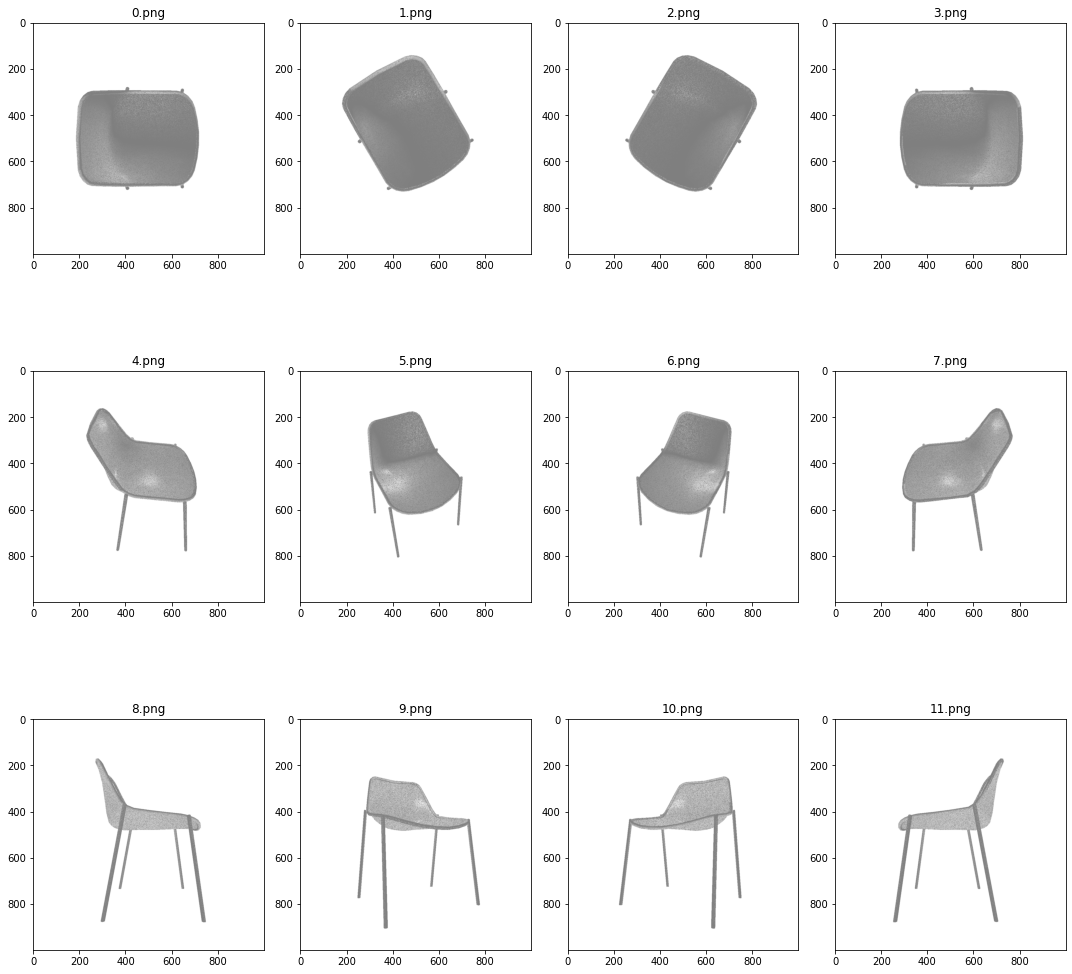

In [4]:
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F

# obj_name = 'airplane_0629'
# obj_name = 'airplane_0630'
# obj_name = 'bookshelf_0574'
# obj_name = 'toilet_0347'
# obj_name = 'toilet_0345'
# obj_name = 'guitar_0157'
# obj_name = 'bathtub_0109'
obj_name = 'chair_0890'
with open("D:/Data/ModelNet40/modelnet40_test_path.txt", 'r') as f:
    paths = f.readlines()
    paths = [path.strip() for path in paths]
# obj_id = paths.index(obj_name[:-5]+'/train/'+obj_name)
obj_id = paths.index(obj_name[:-5]+'/test/'+obj_name)
print(obj_id)

img_folder = f'D:/Data/ModelNet40/{obj_name}/'
imgs = os.listdir(img_folder)
idx = [0,1,2,3,4,5,6,7,8,9,10,11]
imgs = [str(i)+'.png' for i in idx]
plt.figure(figsize=(15, 15))

rendered_imgs = []
for i, img in enumerate(imgs):
    plt.subplot(3,4, i+1)
    im = Image.open(os.path.join(img_folder, img))
    im = torch.tensor(np.array(im))
    # _im = im.sum(dim=-1)
    # _im = 765 - _im
    # pixel_x, pixel_y = torch.nonzero(_im, as_tuple=True)
    # max_l = max(pixel_x.max() - pixel_x.min(), pixel_y.max() - pixel_y.min())
    # center_x = (pixel_x.max() + pixel_x.min()) / 2
    # center_y = (pixel_y.max() + pixel_y.min()) / 2
    # image = torch.zeros(max_l, max_l, 3)
    # s_x = int(center_x - torch.div(max_l,2,rounding_mode='floor'))
    # s_y = int(center_y - torch.div(max_l,2,rounding_mode='floor'))
    # image = image + im[s_x:s_x+max_l, s_y:s_y+max_l, :]
    # image = F.interpolate(image.unsqueeze(0).permute(0,3,1,2), size=(224,224), mode='bilinear', align_corners=True)
    # image = image.squeeze(0).permute(1,2,0)
    # rendered_imgs.append(image)
    # # print(image.shape)
    plt.imshow(im.int())
    plt.title(img)
    
    
plt.tight_layout()



In [5]:
import numpy as np
import torch
for i, img in enumerate(imgs):
    im = Image.open(os.path.join(img_folder, img))
    im = torch.tensor(np.array(im))
    im = im.sum(dim=-1)
    im = 765 - im
    pixel_x, pixel_y = torch.nonzero(im, as_tuple=True)
    print(pixel_x.min(), 223-pixel_x.max(), pixel_y.min(), 223-pixel_y.max())
    # break
    

tensor(59) tensor(59) tensor(49) tensor(50)
tensor(48) tensor(50) tensor(62) tensor(62)
tensor(48) tensor(50) tensor(62) tensor(62)
tensor(59) tensor(59) tensor(50) tensor(49)
tensor(80) tensor(64) tensor(43) tensor(48)
tensor(57) tensor(25) tensor(43) tensor(36)
tensor(57) tensor(25) tensor(36) tensor(43)
tensor(80) tensor(64) tensor(48) tensor(43)
tensor(97) tensor(96) tensor(43) tensor(48)
tensor(99) tensor(90) tensor(56) tensor(47)
tensor(99) tensor(90) tensor(47) tensor(56)
tensor(97) tensor(96) tensor(48) tensor(43)


In [165]:
import pickle
# path = 'D:/Data/ModelNet40/modelnet40_2048_train.dat'
path = 'D:/Data/ModelNet40/modelnet40_test_8192pts_fps.dat'
with open(path, 'rb') as f:
    _points, labels = pickle.load(f)

In [166]:
THETA_NUM, PHI_NUM = 4, 3
idx = [0,1,2,3,4,5,6,7,8,9,10,11]

rotate_num = len(idx)
theta = np.linspace(0, -1, THETA_NUM)
phi = np.linspace(0, -0.5, PHI_NUM)
angles = torch.zeros((THETA_NUM * PHI_NUM, 3))
t = torch.tensor(np.stack(np.meshgrid(phi, theta, indexing='ij'), axis=-1).reshape(-1, 2))
angles[:, 1] = t[:, 0]
angles[:, 2] = t[:, 1]
angles = angles[idx]
print("Multiview angles:", angles)
rotation_matrixs = euler2mat(angles * np.pi)
rotation_matrixs = rotation_matrixs
_align_matrix1 = euler2mat(torch.tensor([0.5*np.pi, 0, 0]))
print(rotation_matrixs.shape)

Multiview angles: tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.3333],
        [ 0.0000,  0.0000, -0.6667],
        [ 0.0000,  0.0000, -1.0000],
        [ 0.0000, -0.2500,  0.0000],
        [ 0.0000, -0.2500, -0.3333],
        [ 0.0000, -0.2500, -0.6667],
        [ 0.0000, -0.2500, -1.0000],
        [ 0.0000, -0.5000,  0.0000],
        [ 0.0000, -0.5000, -0.3333],
        [ 0.0000, -0.5000, -0.6667],
        [ 0.0000, -0.5000, -1.0000]])
torch.Size([12, 3, 3])


In [167]:
import numpy as np
points = _points[obj_id]
pc = np.array(points)
points_center = (pc.min(axis=0, keepdims=True) + pc.max(axis=0, keepdims=True))/2
# pc = pc - points_center
# pc = pc / pc.max()
_pc = pc[:, :3]

print(_pc.shape)
_pc.min(axis=0), _pc.max(axis=0)

(8192, 3)


(array([-0.6488, -0.7567, -0.3822], dtype=float32),
 array([0.6488, 0.9098, 0.441 ], dtype=float32))

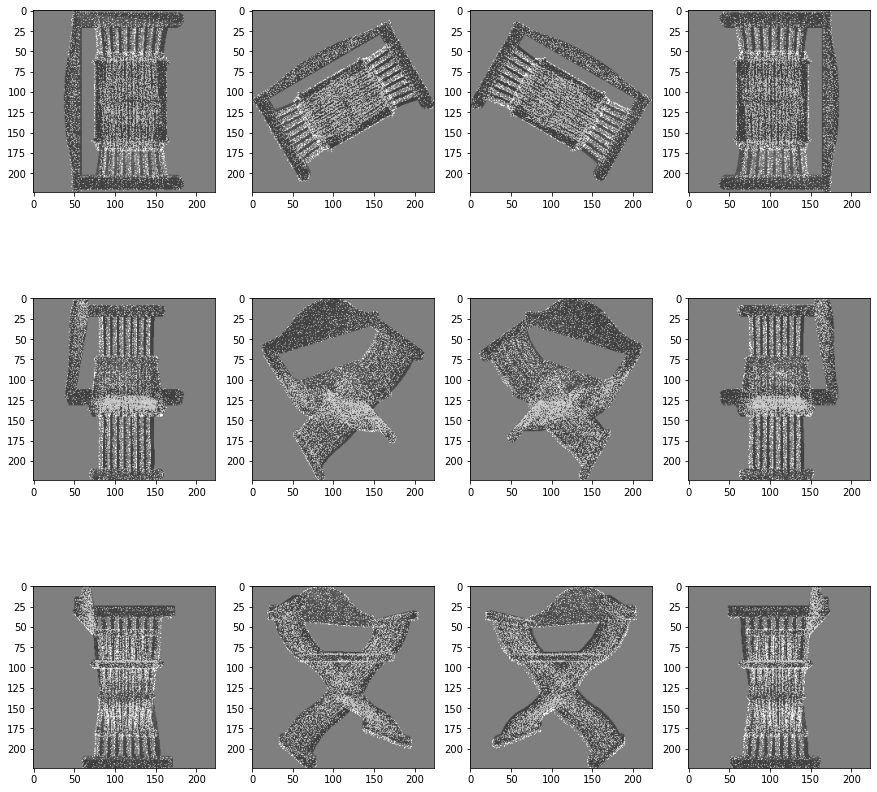

In [168]:
from torch_scatter import scatter
from matplotlib import pyplot as plt

N = _pc.shape[0]
B = 1
obj_size = 224
img_size = 224

intrinsics = torch.tensor([[[ 1.7321,  0.0000,  0.0000,  0.0000],
                            [ 0.0000,  1.7321,  0.0000,  0.0000],
                            [ 0.0000,  0.0000,  1.0101, -1.0101],
                            [ 0.0000,  0.0000,  1.0000,  0.0000]]])

extrinsics = torch.tensor([[[-1.,  0.,  0., -0.],
                             [ 0.,  1.,  0., -0.],
                             [ 0.,  0., -1.,  3.],
                             [ 0.,  0.,  0.,  1.]]])

pc = torch.tensor(_pc).float().unsqueeze(0)
center = (pc.min(dim=1, keepdim=True)[0] + pc.max(dim=1, keepdim=True)[0]) / 2
pc = pc - center
pc = pc / pc.max()
new_pc = pc.unsqueeze(1).repeat(1, rotate_num, 1, 1).reshape(-1, N, 3) # B*R, N, 3

align_matrix = _align_matrix1.float().to(pc.device) # 3, 3
align_matrix = align_matrix.unsqueeze(0).repeat(B*rotate_num, 1, 1).reshape(-1, 3, 3) # B*R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, align_matrix) # B*R, N, 3

rotation_matrix = rotation_matrixs.float().to(pc.device) # R, 3, 3
rotation_matrix = rotation_matrix.unsqueeze(0).repeat(B, 1, 1, 1).reshape(-1, 3, 3) # B*R, 3, 3
new_pc = rotate_point_clouds_batch(new_pc, rotation_matrix) # B*R, N, 3

# new_pc_ = torch.ones((B*rotate_num, N, 4)).to(pc.device)
# new_pc_[:, :, :3] = new_pc
# new_pc_ = torch.bmm(extrinsics.repeat(B*rotate_num, 1, 1), new_pc_.permute(0, 2, 1)) # B*R, 4, N
# # new_pc_ = torch.bmm(intrinsics.repeat(B*rotate_num, 1, 1), new_pc_).permute(0, 2, 1) # B*R, N, 4
# print(new_pc_.max(dim=2)[0])
# print(new_pc_.min(dim=2)[0])
# new_pc = new_pc_

centers = (new_pc.min(dim=1, keepdim=True)[0] + new_pc.max(dim=1, keepdim=True)[0]) / 2
new_pc = new_pc - centers
new_pc = new_pc / new_pc.max()
d = -1.01*new_pc[:, :, 2] + 3
_pc_d = new_pc[:, :, :2] / d.unsqueeze(-1)
n_centers = (_pc_d.min(dim=1, keepdim=True)[0] + _pc_d.max(dim=1, keepdim=True)[0]) / 2
new_pc = _pc_d - n_centers
# new_pc[:, :, :2] = new_pc[:, :, :2] / ((new_pc[:, :, 2] + 2).unsqueeze(-1) * 1)
pc_range = (new_pc.max(dim=1)[0] - new_pc.min(dim=1)[0])[:, :2]  # B*R, 2
grid_size = pc_range.max(dim=-1)[0] / obj_size # B*R
idx_xy = torch.floor(new_pc[:, :, :2] / (grid_size.reshape(-1, 1, 1) + 1e-7))  # B*R, N, 2

idx_xy = idx_xy.long()
center = img_size // 2
idx_xy = idx_xy + center
assert(idx_xy.max() < obj_size)
assert(idx_xy.min() >= 0)
coord = idx_xy[:, :, 0] * img_size + idx_xy[:, :, 1]  # B*R, N

B = rotate_num
images = torch.zeros(B, img_size*img_size, 1).to(pc.device)
pc_val = torch.ones(B, N, 1).to(pc.device) # B N 1
images = scatter(pc_val, coord.long(), dim=1, out=images, reduce="max")
images = images / images.max(dim=1, keepdim=True)[0] * 255
images = images.reshape(rotate_num, img_size, img_size).contiguous()

plt.figure(figsize=(15, 15))
for r in range(rotate_num):
    plt.subplot(3,4, r+1)
    img = images[r].detach().cpu()
    img = img.unsqueeze(2).repeat(1, 1, 3)
    # im = 255-img.long()
    im = (img*0.5 + rendered_imgs[r]*0.5).long()
    plt.imshow(im)

In [199]:
torch.bmm(intrinsics, extrinsics)

tensor([[[-1.7321,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.7321,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0101,  2.0202],
         [ 0.0000,  0.0000, -1.0000,  3.0000]]])

In [86]:
import open3d as o3d
colors = _pc[:, 2] - _pc[:, 2].min()
colors = colors / colors.max()
colors = colors.repeat(3).reshape(-1, 3)
print(colors)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(_pc)
pcd.colors = o3d.utility.Vector3dVector(np.zeros_like(_pc))
o3d.visualization.draw_geometries([pcd])

[[0.18414461 0.18414461 0.18414461]
 [0.04067888 0.04067888 0.04067888]
 [0.29938705 0.29938705 0.29938705]
 ...
 [0.28256747 0.28256747 0.28256747]
 [0.11781994 0.11781994 0.11781994]
 [0.14465197 0.14465197 0.14465197]]


In [155]:
THETA_NUM, PHI_NUM = 4, 3
theta = np.linspace(0, 1, THETA_NUM)
phi = np.linspace(0, 0.5, PHI_NUM)
angles = torch.zeros((THETA_NUM * PHI_NUM, 2))
angles[:, :] = torch.tensor(np.stack(np.meshgrid(phi, theta, indexing='ij'), axis=-1).reshape(-1, 2))
angles = angles[idx]
print("Multiview angles:", angles)
rotation_matrixs = rotate_theta_phi(angles * np.pi)
rotate_num = len(idx)
_align_matrix1 = euler2mat(torch.tensor([0.5*np.pi, 0, 0]))
# _align_matrix2 = euler2mat(torch.tensor([0, -0.5*np.pi, 0]))
print(rotation_matrixs.shape)

Multiview angles: tensor([[0.0000, 0.0000],
        [0.0000, 0.3333],
        [0.0000, 0.6667],
        [0.0000, 1.0000],
        [0.2500, 0.0000],
        [0.2500, 0.3333],
        [0.2500, 0.6667],
        [0.2500, 1.0000],
        [0.5000, 0.0000],
        [0.5000, 0.3333],
        [0.5000, 0.6667],
        [0.5000, 1.0000]])
torch.Size([12, 3, 3])
